In [2]:
import requests
import pandas as pd
import numpy as np
import pickle
import pydmd
import json

import numpy as np
import matplotlib.pyplot as plt

import cvxpy as cp
import os
import pytz

import brickschema

In [3]:
def getResponse(testId, request):
    rsp = requests.get('http://127.0.0.1:5000/{0}'.format(request, testId), headers={'Content-Type': 'application/json'})
    return rsp.json().get('payload')

In [4]:
def putRequest(testId, request, data):
    rsp = requests.put('http://127.0.0.1:5000/{0}'.format(request), data=json.dumps(data), headers={'Content-Type': 'application/json'})
    return rsp.json()

In [5]:
def postRequest(testId, request, data):
    rsp = requests.post('http://127.0.0.1:5000/{0}'.format(request, testId), data=json.dumps(data), headers={'Content-Type': 'application/json'})
    return rsp.json()

In [389]:
def calculate_energy_consumed(df):
    return (df.fcu_reaPHea_y.sum() + df.fcu_reaPCoo_y.sum() + df.fcu_reaPFan_y.sum())/1000

In [725]:
def calculate_discomfort(df, xg, deadband=1.5):
    
    discomfort_df = df.loc[((df.index.hour >= 8) & (df.index.hour < 18))]
    
    discomfort_df_lower = (abs((xg-deadband) - discomfort_df.loc[discomfort_df.zon_reaTRooAir_y< (xg - deadband)].zon_reaTRooAir_y)).sum()
    discomfort_df_upper = (abs(discomfort_df.loc[discomfort_df.zon_reaTRooAir_y> (xg + deadband)].zon_reaTRooAir_y - (xg+deadband))).sum()
    return(discomfort_df_lower + discomfort_df_upper)

In [8]:
def parse_sparql_results(res):
    results = []
    for row in res:
        row_res = []
        for item in row:
            row_res.append(item)
        results.append(row_res)
    return results

In [9]:
training_data_all = []

In [10]:
for file in os.listdir('td3'):
    with open(os.path.join('td3', file), 'rb') as fp:
        training_data = pickle.load(fp)
    training_data_all = training_data_all + training_data

In [11]:
for file in os.listdir('td4'):
    with open(os.path.join('td4', file), 'rb') as fp:
        training_data = pickle.load(fp)
    training_data_all = training_data_all + training_data

In [12]:
training_df = pd.DataFrame(training_data_all)
training_df.time = pd.Timestamp('2021-01-01 00:00:00') + pd.to_timedelta(training_df.time, 's')
training_df = training_df.set_index('time')
training_df['hour'] = training_df.index.hour
training_df.head()

,con_oveTSetCoo_activate,con_oveTSetCoo_u,con_oveTSetHea_activate,con_oveTSetHea_u,fcu_oveFan_activate,fcu_oveFan_u,fcu_oveTSup_activate,fcu_oveTSup_u,fcu_reaFloSup_y,fcu_reaPCoo_y,...,zon_weaSta_reaWeaSolHouAng_y,zon_weaSta_reaWeaSolTim_y,zon_weaSta_reaWeaSolZen_y,zon_weaSta_reaWeaTBlaSky_y,zon_weaSta_reaWeaTDewPoi_y,zon_weaSta_reaWeaTDryBul_y,zon_weaSta_reaWeaTWetBul_y,zon_weaSta_reaWeaWinDir_y,zon_weaSta_reaWeaWinSpe_y,hour
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.0,303.15,0.0,288.15,0.0,0.000000,0.0,294.150000,0.000000,-0.0,...,-3.154887,-182.812399,2.850318,257.167755,265.50,273.15,270.316865,3.342306,2.25,0
2021-01-01 01:00:00,1.0,296.15,1.0,289.15,0.0,0.000000,0.0,294.150000,0.000000,-0.0,...,-2.893169,3416.065337,2.782499,258.454387,266.55,273.15,270.675046,3.543018,2.80,1
2021-01-01 02:00:00,1.0,296.15,1.0,289.15,0.0,0.000000,0.0,294.150000,0.000000,-0.0,...,-2.631452,7014.943528,2.621685,259.085016,267.05,273.15,270.852935,3.543018,3.30,2
2021-01-01 03:00:00,1.0,296.15,1.0,289.15,0.0,0.000000,0.0,294.150000,0.000000,-0.0,...,-2.369734,10613.822175,2.430237,258.940292,266.45,273.15,270.675046,3.141593,3.70,3
2021-01-01 04:00:00,1.0,296.15,1.0,289.15,0.0,0.022993,0.0,294.586865,0.012598,0.0,...,-2.108016,14212.701280,2.230100,258.940292,266.45,273.15,270.675046,3.141593,4.10,4


## Semantic Queries

In [85]:
g = brickschema.Graph()
g.load_file('Brick.ttl')
g.parse('bestest-air.ttl')

<Graph identifier=Nd2aaf06dc82b4b049be602cc3140b4ba (<class 'brickschema.graph.Graph'>)>

In [108]:
state_query = """
    SELECT ?label WHERE  {
     ?state_var a/rdfs:subClassOf* brick:Sensor .
     ?fcu a brick:FCU .
    ?fcu brick:feeds* ?zone .
     ?zone brick:hasPoint ?state_var .
     ?state_var rdfs:label ?label .
    }
"""
control_query = """
    SELECT ?label WHERE  {
     ?control_var a/rdfs:subClassOf* brick:Setpoint .
     ?fcu a brick:FCU .
     ?fcu brick:feeds* ?zone .
     ?zone brick:hasPoint ?control_var .
     ?control_var rdfs:label ?label .
    }
"""
weather_query = """
    SELECT ?label WHERE  {
     ?weather_var a/rdfs:subClassOf* brick:Outside_Air_Temperature_Sensor .
     ?weather_var rdfs:label ?label .
    }
"""

In [109]:
res = g.query(state_query)
ops = parse_sparql_results(res)
state_variables = []
for op in ops:
    state_variables.append(op[0].value)
state_variables

['fcu_reaPHea_y', 'fcu_reaPFan_y', 'fcu_reaPCoo_y', 'zon_reaTRooAir_y']

In [110]:
res = g.query(control_query)
ops = parse_sparql_results(res)
control_variables = []
for op in ops:
    control_variables.append(op[0].value)
control_variables

['con_oveTSetCoo_u', 'con_oveTSetHea_u']

In [111]:
res = g.query(weather_query)
ops = parse_sparql_results(res)
weather_variables = []
for op in ops:
    weather_variables.append(op[0].value)
weather_variables

['zon_weaSta_reaWeaTDryBul_y']

In [112]:
relevant_cols = state_variables + control_variables + weather_variables

In [114]:
training_df[relevant_cols]

,fcu_reaPHea_y,fcu_reaPFan_y,fcu_reaPCoo_y,zon_reaTRooAir_y,con_oveTSetCoo_u,con_oveTSetHea_u,zon_weaSta_reaWeaTDryBul_y
time,,,,,,,
2021-01-01 00:00:00,0.000000e+00,0.000000,-0.000000e+00,293.150000,303.15,288.15,273.15
2021-01-01 01:00:00,0.000000e+00,0.000000,-0.000000e+00,290.405097,296.15,289.15,273.15
2021-01-01 02:00:00,0.000000e+00,0.000000,-0.000000e+00,289.867101,296.15,289.15,273.15
2021-01-01 03:00:00,0.000000e+00,0.000000,-0.000000e+00,289.418363,296.15,289.15,273.15
2021-01-01 04:00:00,7.721144e+01,0.010333,0.000000e+00,289.136092,296.15,289.15,273.15
...,...,...,...,...,...,...,...
2021-01-30 20:00:00,0.000000e+00,0.000000,5.888277e-251,296.902168,303.15,294.15,269.25
2021-01-30 21:00:00,3.879429e-301,0.000000,0.000000e+00,296.101724,303.15,294.15,269.25
2021-01-30 22:00:00,0.000000e+00,0.000000,-0.000000e+00,295.293662,303.15,294.15,269.25


In [122]:
df2 = training_df[relevant_cols]
df2['power'] = df2.fcu_reaPHea_y + df2.fcu_reaPFan_y + df2.fcu_reaPCoo_y
df2['hour'] = df2.index.hour
df2['weekday'] = (df2.index.weekday < 5).astype(int)

/var/folders/wr/4z6htfvj0hj_mk0vb5t14xs00000gn/T/ipykernel_46040/96007738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['power'] = df2.fcu_reaPHea_y + df2.fcu_reaPFan_y + df2.fcu_reaPCoo_y
/var/folders/wr/4z6htfvj0hj_mk0vb5t14xs00000gn/T/ipykernel_46040/96007738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hour'] = df2.index.hour
/var/folders/wr/4z6htfvj0hj_mk0vb5t14xs00000gn/T/ipykernel_46040/96007738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [133]:
x_columns = ['zon_reaTRooAir_y', 'power']
u_columns = control_variables.copy()
w_columns = weather_variables.copy()
relevant_cols = x_columns + u_columns + w_columns + ['hour']

In [135]:
df2[relevant_cols].head()

,zon_reaTRooAir_y,power,con_oveTSetCoo_u,con_oveTSetHea_u,zon_weaSta_reaWeaTDryBul_y,hour
time,,,,,,
2021-01-01 00:00:00,293.150000,0.000000,303.15,288.15,273.15,0
2021-01-01 01:00:00,290.405097,0.000000,296.15,289.15,273.15,1
2021-01-01 02:00:00,289.867101,0.000000,296.15,289.15,273.15,2
2021-01-01 03:00:00,289.418363,0.000000,296.15,289.15,273.15,3
2021-01-01 04:00:00,289.136092,77.221776,296.15,289.15,273.15,4


In [136]:
from sklearn.linear_model import LinearRegression

X = df2[relevant_cols].values[:-1]
y = df2[x_columns].values[1:]

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

0.9123842372540791


In [137]:
relevant_cols

['zon_reaTRooAir_y',
 'power',
 'con_oveTSetCoo_u',
 'con_oveTSetHea_u',
 'zon_weaSta_reaWeaTDryBul_y',
 'hour']

In [138]:
prediction_horizon = 24 #hours
initial_ts = 0

In [139]:
nx = len(x_columns)
nu = len(u_columns)

In [140]:
reg_coeff = reg.coef_
intercept = reg.intercept_

In [145]:
xg = 273.15 + 22.5
Q1 = np.ones((1, 1))
Q2 = np.ones((1, 1))
R = np.diag(np.ones(nu))

In [912]:
st = pd.Timestamp('2021-01-01 00:00:00')
num_prediction_days = 7
U_optimal = np.zeros((nu, int(num_prediction_days*24)))

payload = putRequest('', 'initialize', {'start_time': 0, 'warmup_period': 0})

for time_delta in range(0, int(num_prediction_days*24), 1):
    time = st + pd.Timedelta(time_delta, 'h')
    cost = 0 
    constraints = []
    X = cp.Variable((nx, prediction_horizon))
    U = cp.Variable((nu, prediction_horizon-1))
    if time_delta == 0:
        x0 = np.array([df2.loc[time, 'zon_reaTRooAir_y'].values[0], df2.loc[time, 'power'].values[0]])
    else: 
        dataInput = {
                    'con_oveTSetCoo_u': U_optimal[0, time_delta-1], 
                    'con_oveTSetHea_u': U_optimal[1, time_delta-1],
                    'con_oveTSetCoo_activate': True, 
                    'con_oveTSetHea_activate': True,
                    'fcu_oveFan_activate': False,
                    'fcu_oveTSup_activate': False,
                }

        payload = postRequest('', 'advance', data=dataInput).get('payload')
        x0 = np.array([payload.get('zon_reaTRooAir_y'), payload.get('fcu_reaPHea_y') + payload.get('fcu_reaPCoo_y') + payload.get('fcu_reaPFan_y')])
    
    model_input = []
    for i in range(1,prediction_horizon-1):
        current_time = time + pd.Timedelta(hours=i)
        if current_time.hour >= 8 and current_time.hour < 18:
            cost += 0.5*cp.quad_form(X[0:1, i]-xg, Q1)
        cost += 0.5*cp.quad_form(X[1:, i], 22*Q2)
        cost += 0.5*cp.quad_form(U[:, i], R)
        
        oat = df2.loc[current_time, 'zon_weaSta_reaWeaTDryBul_y'].values[0]
        hour = current_time.hour
        
        model_input = np.array([
            [
                X[0, i], 
                X[1, i], 
                U[0, i], 
                U[1, i], 
                oat, 
                hour,
            ]
        ])
        constraints.append(X[0, i+1] == (((reg_coeff * model_input)[0]).sum() + intercept)[0])
        constraints.append(X[1, i+1] == (((reg_coeff * model_input)[1]).sum() + intercept)[1])
        
    cost += 0.5*cp.quad_form(X[0:1, prediction_horizon-1]-xg, 100*Q1)
    cost += 0.5*cp.quad_form(X[1:, prediction_horizon-1], 100*Q2)
    
    # cooling setpoint 
    constraints.append(U[0, :] >= 296.15)
    constraints.append(U[0, :] <= 303.15)
    # # heating setpoint
    constraints.append(U[1, :] >= 288.15)
    constraints.append(U[1, :] <= 296.15)
    
    constraints.append(U[0, :] >= U[1, :]+3)
    
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    problem.solve(solver=cp.SCS, verbose=False)

    U_optimal[0, time_delta] = min(U[0, 1].value, 303.15)
    U_optimal[0, time_delta] = max(U[0, 1].value, 296.15)
    U_optimal[1, time_delta] = max(U[1, 1].value, 288.15)
    U_optimal[1, time_delta] = min(U[1, 1].value, 296.15)
        

In [913]:
U_optimal

array([[296.1505368 , 296.15025892, 296.15286866, 296.15      ,
        296.15      , 296.15      , 299.14989674, 299.14921878,
        299.1499784 , 299.14990774, 299.14995164, 299.15270496,
        299.14998844, 299.15018543, 299.149522  , 299.14971905,
        299.15187795, 299.14995525, 299.15107468, 299.15085153,
        299.15123597, 299.14989777, 299.15247264, 299.1500819 ,
        299.14964367, 299.14809934, 299.15075666, 299.14998185,
        299.14997987, 299.14995933, 299.14977227, 299.14923867,
        299.14920716, 299.14932561, 299.1491692 , 299.14993062,
        299.14968083, 299.14891608, 299.15193482, 299.14864217,
        299.15258799, 299.15056985, 299.14996588, 299.1499328 ,
        299.15116996, 299.15023842, 299.15005329, 299.15018315,
        299.14980733, 299.14981474, 299.15026493, 299.15142581,
        299.14995025, 299.14995232, 299.14998825, 299.14990834,
        299.14949018, 299.14913461, 299.14892615, 299.14946986,
        299.15037366, 299.15008398, 299.

## control KPI 

In [914]:
stepSize = 60*60
putRequest('', 'step', {'step': stepSize})

payload = putRequest('', 'initialize', {'start_time': 0, 'warmup_period': 0})
control_measurements = []
control_measurements.append(payload['payload'])
for i in range(int(num_prediction_days*24)):
    control_data={
            'con_oveTSetCoo_u': U_optimal[0, i], 
            'con_oveTSetHea_u': U_optimal[1, i],
            'con_oveTSetCoo_activate': True, 
            'con_oveTSetHea_activate': True,
            'fcu_oveFan_activate': False,
            'fcu_oveTSup_activate': False,
        }
    payload = postRequest('', 'advance', data=control_data).get('payload')
    control_measurements.append(payload)

In [915]:
control_df = pd.DataFrame(control_measurements)
control_df.time = pd.Timestamp('2021-01-01 00:00:00') + pd.to_timedelta(control_df.time, 's')
control_df['hour'] = control_df.time.dt.hour
control_df['weekday'] = (control_df.time.dt.weekday < 5).astype(int)
control_df = control_df.set_index('time')
control_df = control_df[state_variables + control_variables + weather_variables]
control_df['target'] = xg

## baseline data

In [916]:
stepSize = 60*60
putRequest('', 'step', {'step': stepSize})

payload = putRequest('', 'initialize', {'start_time': 0, 'warmup_period': 0})
baseline_measurements = []
baseline_measurements.append(payload['payload'])
for i in range(int(num_prediction_days*24)):
    baseline_data={
            'con_oveTSetCoo_activate': False, 
            'con_oveTSetHea_activate': False,
            'fcu_oveFan_activate': False,
            'fcu_oveTSup_activate': False,
        }
    payload = postRequest('', 'advance', data=baseline_data).get('payload')
    baseline_measurements.append(payload)

In [917]:
baseline_df = pd.DataFrame(baseline_measurements)
baseline_df.time = pd.Timestamp('2021-01-01 00:00:00') + pd.to_timedelta(baseline_df.time, 's')
baseline_df['hour'] = baseline_df.time.dt.hour
baseline_df['weekday'] = (baseline_df.time.dt.weekday < 5).astype(int)
baseline_df = baseline_df.set_index('time')
baseline_df = baseline_df[state_variables + control_variables + weather_variables]

In [918]:
print("mpc discomfort: {}".format(calculate_discomfort(control_df, 273.15+22.5)))
print("mpc energy: {}".format(calculate_energy_consumed(control_df)))

mpc discomfort: 60.075947327362485
mpc energy: 222.4408846678906


In [919]:
print("baseline discomfort: {}".format(calculate_discomfort(baseline_df, 273.15+22.5)))
print("baseline energy: {}".format(calculate_energy_consumed(baseline_df)))

baseline discomfort: 41.13144340135926
baseline energy: 164.7759472839542


In [920]:
mpc_energy = calculate_energy_consumed(control_df)
baseline_energy = calculate_energy_consumed(baseline_df)

print((baseline_energy-mpc_energy)/baseline_energy*100)

-34.99596775769942


In [921]:
control_discomfort = calculate_discomfort(control_df, 273.15+22.5)
baseline_discomfort = calculate_discomfort(baseline_df, 273.15+22.5)

print((baseline_discomfort - control_discomfort)/baseline_discomfort * 100)

-46.058446675803175


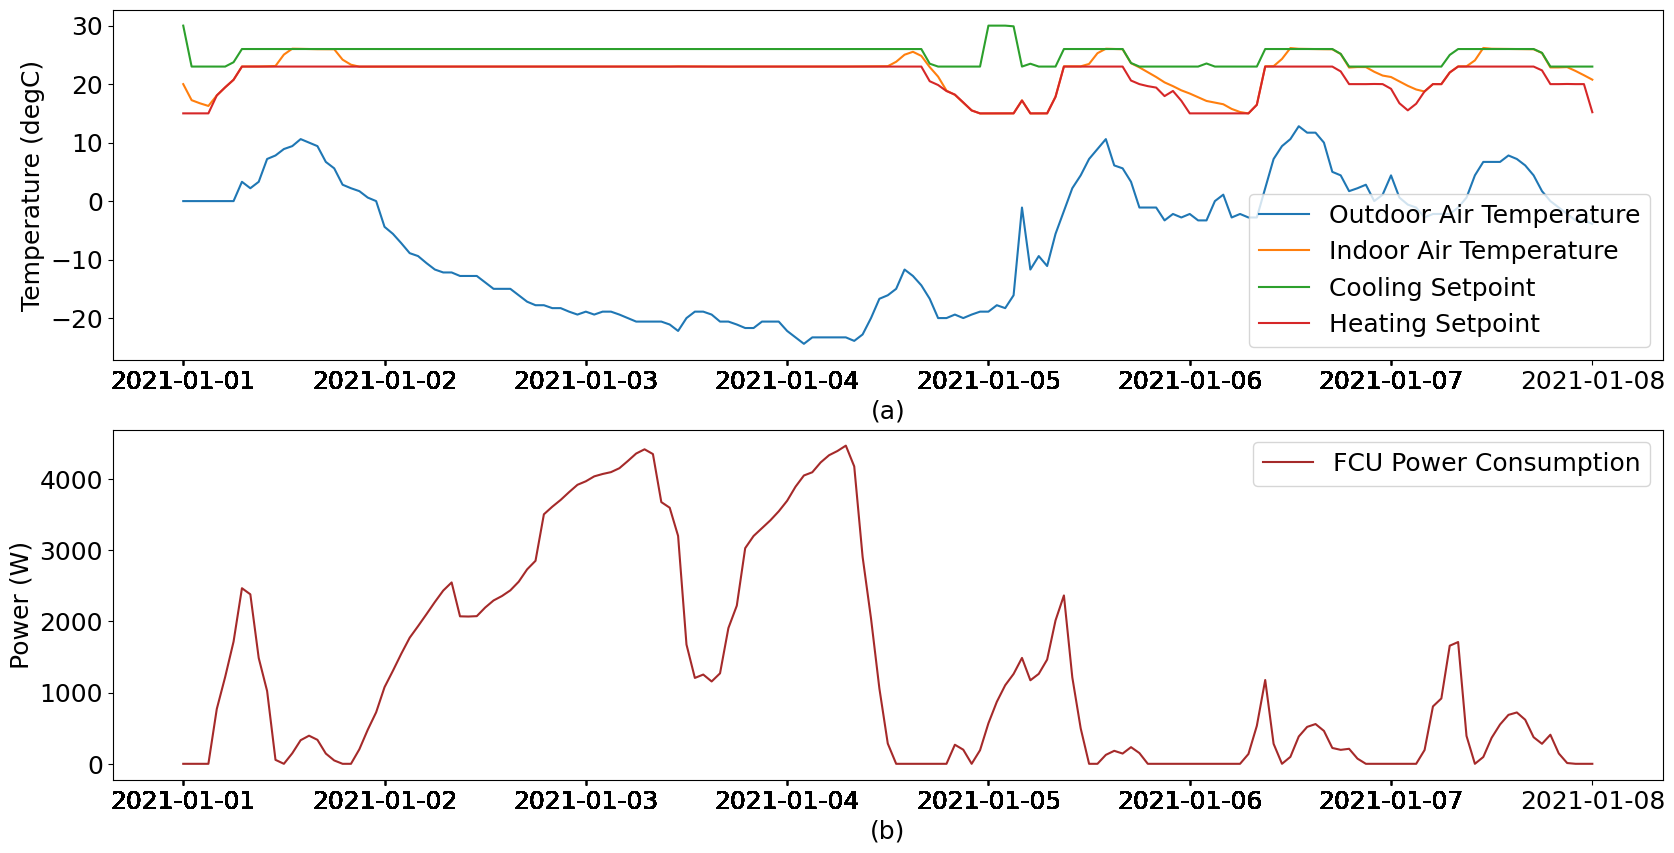

In [910]:
plot_df = control_df.copy()
# plot_df = plot_df.tz_localize(pytz.UTC)
# plot_df = plot_df.tz_convert(pytz.timezone("America/Chicago")).loc["2021-01-05"]
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 18
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

l1 = ax1.plot(plot_df.zon_weaSta_reaWeaTDryBul_y-273.15, label='Outdoor Air Temperature')
l2 = ax1.plot(plot_df.zon_reaTRooAir_y-273.15, label='Indoor Air Temperature')
l3 = ax1.plot(plot_df.con_oveTSetCoo_u-273.15, label='Cooling Setpoint')
l4 = ax1.plot(plot_df.con_oveTSetHea_u-273.15, label='Heating Setpoint')
ax1.set_ylabel('Temperature (degC)')

l6 = ax2.plot(plot_df.fcu_reaPHea_y+plot_df.fcu_reaPCoo_y+plot_df.fcu_reaPFan_y, label='FCU Power Consumption', color='brown')
ax2.set_ylabel('Power (W)')
ax1.set_xlabel('(a)')
ax2.set_xlabel('(b)')

_ = ax1.set_xticks(plot_df.index.strftime("%Y-%m-%d"))
_ = ax1.set_xticklabels(labels=plot_df.index.strftime("%Y-%m-%d"))
_ = ax2.set_xticks(plot_df.index.strftime("%Y-%m-%d"))
_ = ax2.set_xticklabels(labels=plot_df.index.strftime("%Y-%m-%d"))

ax1.legend(loc=4)
ax2.legend()

plt.savefig('charts/result-mpc2.pdf')

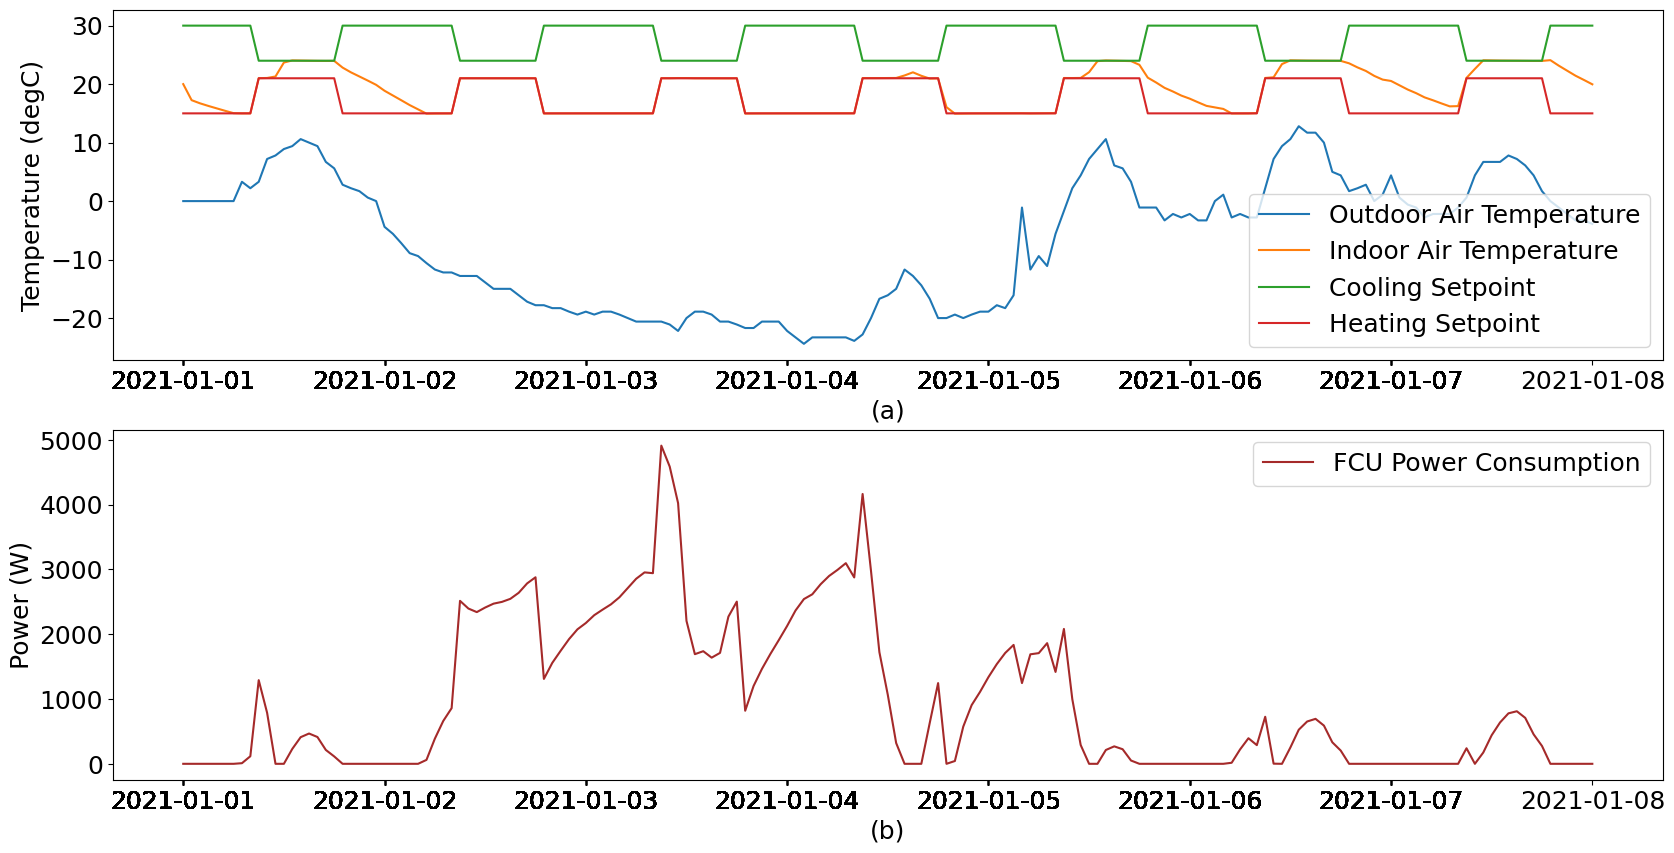

In [911]:
plot_df = baseline_df.copy()
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 18
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

l1 = ax1.plot(plot_df.zon_weaSta_reaWeaTDryBul_y-273.15, label='Outdoor Air Temperature')
l2 = ax1.plot(plot_df.zon_reaTRooAir_y-273.15, label='Indoor Air Temperature')
l3 = ax1.plot(plot_df.con_oveTSetCoo_u-273.15, label='Cooling Setpoint')
l4 = ax1.plot(plot_df.con_oveTSetHea_u-273.15, label='Heating Setpoint')
ax1.set_ylabel('Temperature (degC)')

l6 = ax2.plot(plot_df.fcu_reaPHea_y+plot_df.fcu_reaPCoo_y+plot_df.fcu_reaPFan_y, label='FCU Power Consumption', color='brown')
ax2.set_ylabel('Power (W)')
ax1.set_xlabel('(a)')
ax2.set_xlabel('(b)')

_ = ax1.set_xticks(baseline_df.index.strftime("%Y-%m-%d"))
_ = ax1.set_xticklabels(labels=baseline_df.index.strftime("%Y-%m-%d"))
_ = ax2.set_xticks(baseline_df.index.strftime("%Y-%m-%d"))
_ = ax2.set_xticklabels(labels=baseline_df.index.strftime("%Y-%m-%d"))

ax1.legend()
ax2.legend()

# plt.savefig('charts/baseline.png')

In [839]:
# new_X = df2[reg_columns].values[:-1][:int(num_prediction_days*24)]

# for i in range(int(num_prediction_days * 24)):
#     new_X[i, 0] = U_optimal[0, i]
#     new_X[i, 1] = U_optimal[1, i]
#     # new_X[i, 2] = U_optimal[2, i]
#     # new_X[i, 3] = U_optimal[3, i]
    
# print(temp_reg.predict(new_X))
# print(power_reg.predict(new_X))

In [692]:
# df = pd.DataFrame(index = pd.date_range(start=st, end=st+pd.Timedelta(int(num_prediction_days*24), unit='h'), freq='1h', inclusive='left'),
#              data = {
#                  'oat': new_X[:, nu],
#                  'power': power_reg.predict(new_X),
#                  'indoor': temp_reg.predict(new_X),
#                  'csp': new_X[:, 0],
#                  'hsp': new_X[:, 1],
#              })
# df.to_csv('output.csv')

In [712]:

# plt.plot(temp_reg.predict(new_X)-273.15, label='tzon_pred')
# plt.plot(new_X[:, 0]-273.15, label='tcoosp')
# plt.plot(new_X[:, 1]-273.15, label='theap')
# plt.plot(new_X[:, nu]-273.15, label='TOut')
# plt.xticks(ticks=range(0, num_prediction_days*24+1, 12), labels=pd.date_range(start=st, end=st+pd.Timedelta(int(num_prediction_days*24), unit='h'), freq='12h'), rotation=90)
# # plt.plot(temp_reg.predict(U_optimal[1, :])-273.15)
# # plt.plot(np.ones(int(num_prediction_days*24))*(21), label='lower')
# # plt.plot(np.ones(int(num_prediction_days*24))*(24), label='upper')
# plt.legend()

In [713]:
# plt.plot(power_reg.predict(new_X), label='power')